<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/main/ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch on Ray on Vertex AI

https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/ray_on_vertex_ai/get_started_with_pytorch_rov.ipynb

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

https://medium.com/google-cloud/ray-got-new-friends-orchestrating-ray-based-ml-pipeline-on-vertex-ai-5f243eaf2947

* As you use vertex ai pipelines to distribute training with tensorflow  and torch
* You can adopt ray as unique framework to distribute training (and more)
* But it will always be a component in the overall ML workflow (e.g. with kubeflow)
* also we are working on ray serverless in colab with dataproc team
* so it is going to be sooooo easy to orchestrate ray on vertex ai


## Overview

This tutorial demonstrates how to use Ray on Vertex AI SDK and Vertex AI SDK for training and serving an PyTorch image classification model.

Learn more about [Ray on Vertex AI overview](https://cloud.google.com/vertex-ai/docs/open-source/ray-on-vertex-ai/overview).

### Objective

In this tutorial, you learn how to efficiently distribute the training process of a PyTorch image classification model by leveraging Ray on Vertex AI. Furthermore, you learn how to deploy the trained model seamlessly to Vertex AI Endpoint.

This tutorial uses the following Google Cloud ML services and resources:

- Ray on Vertex AI
- Vertex AI Model Registry
- Vertex AI Prediction


The steps performed include:

- Prepare the training script
- Submit a Ray job using the Ray Jobs API
- Download a trained image model from PyTorch
- Create a custom model handler
- Package model artifacts in a model archive file
- Register model in Vertex AI Model Registry
- Deploy model in Vertex AI Endpoint
- Make online predictions

### Dataset

This tutorial uses the [CIFAR-10 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

https://cloud.google.com/blog/products/ai-machine-learning/ray-on-vertex-ai

## Get started

### Install Vertex AI SDK for Python and other required packages


In [ ]:
! pip3 install google-cloud-aiplatform[ray]==1.56.0 ray[data,train,tune,serve] google-cloud-bigquery-storage pyarrow gcsfs setuptools==69.5.1 "numpy<2" -q --no-warn-conflicts
! pip3 install torch==2.1.2 torchvision==0.16.2 torchmetrics==1.2.1 torchserve==0.9.0 torch-model-archiver==0.9.0 -q --no-warn-conflicts
! pip3 install google-auth==2.27.0 etils==1.5.2 -q --no-warn-conflicts

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK for Python

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "lunar-352813"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = "gs://energy-lunar-352813-001"  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://energy-lunar-352813-001/...


### Initialize Vertex AI SDK for Python

In [ ]:
from google.cloud import aiplatform as vertex_ai

vertex_ai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Add torch-model-archiver to the PATH

Update the `PATH` environment variable to add `torch-model-archiver`

In [ ]:
import os

os.environ["PATH"] = f'{os.environ.get("PATH")}:~/.local/bin'

### Set a Ray cluster on Vertex AI

Before running the code below, make sure to [set up](https://cloud.google.com/vertex-ai/docs/open-source/ray-on-vertex-ai/set-up) Ray on Vertex AI and [create](https://cloud.google.com/vertex-ai/docs/open-source/ray-on-vertex-ai/create-cluster) at least one Ray cluster on Vertex AI.

In [ ]:
import vertex_ray
from vertex_ray import Resources

#### Define cluster configuration

To provision a Ray cluster on Vertex AI, you can use a default provisioning request or you can specify the replica count (number of nodes), machine type, disk_spec, and accelerator as needed.

In [ ]:
head_node_type = Resources(
    machine_type="n1-standard-16",
    node_count=1,
)

worker_node_types = [
    Resources(
        machine_type="n1-standard-16",
        node_count=2,
    )
]

#### Create the Ray cluster

Create the Ray cluster using the Vertex AI SDK for Python version used with Ray.

In [ ]:
# The latest image in the Ray cluster includes Ray 2.33
# The latest supported Python version is Python 3.10
!pip install google-cloud-aiplatform[ray]

In [ ]:
cluster_name = f"ray-cluster-{TIMESTAMP}"

In [ ]:
ray_cluster_name = vertex_ray.create_ray_cluster(
    head_node_type=head_node_type,
    worker_node_types=worker_node_types,
    cluster_name=cluster_name,
)

[Ray on Vertex AI]: Cluster State = State.PROVISIONING
Waiting for cluster provisioning; attempt 1; sleeping for 0:02:30 seconds
[Ray on Vertex AI]: Cluster State = State.PROVISIONING
Waiting for cluster provisioning; attempt 2; sleeping for 0:01:54.750000 seconds
[Ray on Vertex AI]: Cluster State = State.PROVISIONING
Waiting for cluster provisioning; attempt 3; sleeping for 0:01:27.783750 seconds
[Ray on Vertex AI]: Cluster State = State.PROVISIONING
Waiting for cluster provisioning; attempt 4; sleeping for 0:01:07.154569 seconds
[Ray on Vertex AI]: Cluster State = State.PROVISIONING
Waiting for cluster provisioning; attempt 5; sleeping for 0:00:51.373245 seconds
[Ray on Vertex AI]: Cluster State = State.PROVISIONING
Waiting for cluster provisioning; attempt 6; sleeping for 0:00:39.300532 seconds
[Ray on Vertex AI]: Cluster State = State.PROVISIONING
Waiting for cluster provisioning; attempt 7; sleeping for 0:00:30.064907 seconds
[Ray on Vertex AI]: Cluster State = State.PROVISIONING


#### Get the Ray cluster

Use the Vertex AI SDK for Python to get the Ray cluster.

In [ ]:
ray_cluster = vertex_ray.get_ray_cluster(ray_cluster_name)
print("Ray cluster on Vertex AI:", ray_cluster_name)

Ray cluster on Vertex AI: projects/892203813305/locations/us-central1/persistentResources/ray-cluster-20240913115231


### Set tutorial folder

Set up the folder you use in this tutorial.

In [ ]:
from pathlib import Path as path

root_path = path.cwd()
tutorial_path = root_path / "tutorial"
src_path = tutorial_path / "src"
deliverables_path = tutorial_path / "deliverables"
build_path = tutorial_path / "build"
tests_path = tutorial_path / "tests"

src_path.mkdir(parents=True, exist_ok=True)
deliverables_path.mkdir(parents=True, exist_ok=True)
build_path.mkdir(parents=True, exist_ok=True)
tests_path.mkdir(parents=True, exist_ok=True)

### Import libraries

In [ ]:
import base64
import io
import os
import random
import shutil
import string
import time

# Ray - Training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# General
from etils import epath
from matplotlib import pyplot as plt
from ray.job_submission import JobStatus, JobSubmissionClient
# Serving
from ray.tune import ExperimentAnalysis
from vertex_ray.predict import torch as ray_torch

### Set variables

In [ ]:
# training
LOGGING_URI = epath.Path(BUCKET_URI) / "logs"
EXPERIMENT_NAME = "torch_on_rov"
TRAINING_URI = LOGGING_URI / EXPERIMENT_NAME
TRAINING_PATH = deliverables_path / EXPERIMENT_NAME

# serving
DELIVERABLES_PATH = str(deliverables_path)
BUILD_URI = str(epath.Path(BUCKET_URI) / "build")
DEPLOY_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/pytorch-cpu.1-11:latest"
MODEL_NAME = "torch_on_rov_cifar10"
DEPLOY_COMPUTE = "n1-standard-4"

### Define helpers

In [ ]:
def get_id(k=3):
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=k))


def plot_image_sample(test_dataset):
    """Plots a sample image from the CIFAR-10 dataset."""

    sample_idx = random.randrange(0, len(test_dataset))
    image, _ = test_dataset[sample_idx]
    pil_image = transforms.ToPILImage()(image)
    plt.imshow(pil_image)
    plt.show()

    return pil_image


def predict_from_image(pil_image, endpoint):
    """Predicts the class of an image using the given endpoint."""
    buffered_image = io.BytesIO()
    pil_image.save(buffered_image, format="JPEG")

    data = {"data": base64.b64encode(buffered_image.getvalue()).decode("utf-8")}
    response = endpoint.predict(instances=[data])

    return response.predictions

## Training a PyTorch model

In this tutorial, you train a custom image classification model using Ray on Vertex AI.

#### Prepare the training application

Before you start the training, let's take a look at how a Ray job might be assembled to distribute your training.

Ray 2.4.0 uses `train_loop_per_worker` fuction to a distributed multi-worker training function.

After you set up your dataset and your model, define your single-worker PyTorch training function and then convert it to distributed multi-worker training function as followed:

1. Use the `ray.train.torch.prepare_data_loader` to wrap your data with  `DistributedSampler` for distributed training.

2. Use the `ray.train.torch.prepare_model` function to wrap your model with  `DistributedDataParallel` for distributed training.

After you have your multi-worker training function, you need to define the `ScalingConfig` to specify the desired number of workers and indicate whether the distributed training process requires GPUs.

Additionally, you can define a `RunConfig` to specify checkpointing and synchronization behaviors along the distributed training workload and some additional training loop parameters.

Finally, pass everything to `TorchTrainer`, which Ray uses to distribute your training utilizing Distributed Data Parallelism (using PyTorch’s Distributed backend).

### Prepare the training script

The file `src/task.py` is the Python script for executing the Ray distributed training job.

In [ ]:
training_script = """
# libraries

# general libraries
import os
import argparse
from etils import epath
import tempfile

# training libraries
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchmetrics.aggregation import MeanMetric
from torchmetrics.classification.accuracy import Accuracy

# ray libraries
import ray
from ray import train
from ray.train import ScalingConfig, RunConfig, CheckpointConfig, Checkpoint, FailureConfig
from ray.train.torch import TorchTrainer, TorchCheckpoint


# helpers
def get_args():
    parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
    parser.add_argument('--batch-size', dest='batch_size',
                        type=int, default=16, help='Batch size')
    parser.add_argument('--epochs', dest='epochs',
                        type=int, default=10, help='Number of epochs')
    parser.add_argument('--lr', dest='lr',
                        type=int, default=1e-3, help='Learning rate')
    parser.add_argument('--num-workers', dest='num_workers',
                        type=int, default=1, help='Number of workers')
    parser.add_argument('--use-gpu', dest='use_gpu', action='store_true',
                        default=False, help='Use GPU')
    parser.add_argument('--experiment-name', dest='experiment_name', type=str,
                        default='cifar10-torch', help='Experiment name')
    parser.add_argument('--logging-dir', dest='logging_dir',
                        type=str, default='./logs', help='Logging directory')
    args = parser.parse_args()
    return args

# Create a simple model
class Cifar10Model(nn.Module):
    def __init__(self):
        super(Cifar10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_epoch(train_loader, model, loss_fn, optimizer, device):
    # initiate training
    model.train()
    train_loss = MeanMetric()
    train_accuracy = Accuracy(task="multiclass", num_classes=10)

    # load metrics to device
    train_loss.to(device)
    train_accuracy.to(device)

    # training loop
    for batch, (data, target) in enumerate(train_loader):
        # move data to device
        data = data.to(device)
        target = target.to(device)

        # compute error
        output = model(data)
        loss = loss_fn(output, target)
        train_loss.update(loss)
        train_accuracy.update(output, target)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print results
        if batch % 100 == 0:
            print(f'batch {batch}, loss {loss.item():.4f}')

    # compute loss and metrics
    train_loss = Tensor.numpy(train_loss.compute(), force=True).item()
    train_accuracy = Tensor.numpy(train_accuracy.compute(), force=True).item()

    return train_loss, train_accuracy


def evaluate_epoch(test_loader, model, loss_fn, device):
    # initiate evaluation
    model.eval()
    test_loss = MeanMetric()
    test_accuracy = Accuracy(task="multiclass", num_classes=10)

    # load metrics to device
    test_loss.to(device)
    test_accuracy.to(device)

    # evaluation loop
    for batch, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            # move data to device
            data = data.to(device)
            target = target.to(device)

            # get loss and accuracy
            output = model(data)
            test_loss.update(loss_fn(output, target))
            test_accuracy.update(output, target)

    # compute loss and metrics
    test_loss = Tensor.numpy(test_loss.compute(), force=True).item()
    test_accuracy = Tensor.numpy(test_accuracy.compute(), force=True).item()

    return test_loss, test_accuracy


def train_loop_per_worker(config):
    # set configuration
    batch_size = config["batch_size"]
    epochs = config["epochs"]
    learning_rate = config["learning_rate"]

    # get device
    device = train.torch.get_device() if torch.cuda.is_available() else torch.device("cpu")

    # read dataset
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    transform = transforms.Compose([transforms.ToTensor(), normalize])

    # Setting url as a fix as mentioned in github issue https://github.com/pytorch/vision/issues/5039#issuecomment-1309696669
    datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    train_dataset = datasets.CIFAR10(root="./train",
                                     transform=transform,
                                     train=True, download=True)

    test_dataset = datasets.CIFAR10(root="./test",
                                    transform=transform,
                                    train=False, download=True)

    # create data loaders
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size)
    train_loader = train.torch.prepare_data_loader(train_loader)
    test_loader = train.torch.prepare_data_loader(test_loader)

    # create model
    model = Cifar10Model()
    model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train model
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train_epoch(train_loader, model, loss_fn, optimizer, device)
        test_loss, test_accuracy = evaluate_epoch(test_loader, model, loss_fn, device)

        # report metrics and model checkpoint
        train.report(
            metrics={"train_loss": train_loss, "train_accuracy": train_accuracy,
                     "test_loss": test_loss, "test_accuracy": test_accuracy},
            checkpoint=TorchCheckpoint.from_state_dict(model.state_dict())
        )


def main():
    # set configuration
    args = get_args()
    config = vars(args)

    # initialize ray session
    ray.init()

    # train model
    train_loop_config = {"learning_rate": config['lr'], "batch_size": config['batch_size'],
                         "epochs": config['epochs']}
    scaling_config = ScalingConfig(num_workers=config['num_workers'], use_gpu=config['use_gpu'])
    run_config = RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=1),
                           storage_path=config['logging_dir'],
                           name=config['experiment_name'],
                           failure_config=FailureConfig(max_failures=5))

    trainer = TorchTrainer(
        train_loop_per_worker=train_loop_per_worker,
        train_loop_config=train_loop_config,
        run_config=run_config,
        scaling_config=scaling_config
    )
    result = trainer.fit()
    print(f"Last result: {result.metrics}")


if __name__ == "__main__":
    main()
"""

with open(src_path / "task.py", "w") as f:
    f.write(training_script)
f.close()

### Prepare the requirements file

The file `requirements.txt` includes the dependencies your Ray application needs to run.

In [ ]:
requirements = """
importlib_resources==6.1.1
etils==1.5.2
ray[data]==2.9.3
ray[train]==2.9.3
ray[tune]==2.9.3
torch==2.1.2
torchvision==0.16.2
torchmetrics==1.2.1
setuptools==69.5.1
numpy<2
"""

with open(tutorial_path / "requirements.txt", "w") as f:
    f.write(requirements)
f.close()

### Submit a Ray job using the Ray Jobs API

Submit the script to the Ray cluster on Vertex AI using the Ray Jobs API with  the public Ray dashboard address.

It's important to highlight that Ray Jobs API is the prefered option if you'd rather submit jobs programmatically. You can also use the Ray on Vertex AI SDK if you prefer an interactive Python development environment.

Initiate the client to submit the job.

In [ ]:
client = JobSubmissionClient(address=f"vertex_ray://{ray_cluster.dashboard_address}")

Submit the job.

In [ ]:
id = get_id()

job_id = client.submit_job(
    submission_id=f"ray-job-{TIMESTAMP}-{id}",
    entrypoint=f"python3 task.py --experiment-name={EXPERIMENT_NAME} --num-workers=2 --logging-dir={LOGGING_URI}",
    runtime_env={
        "pip": {"packages": str(tutorial_path / "requirements.txt")},
        "working_dir": str(src_path),
    },
)

2024-09-13 12:09:12,633	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_7f650b2d1ed3deea.zip.
2024-09-13 12:09:12,636	INFO packaging.py:530 -- Creating a file package for local directory '/content/tutorial/src'.


Check the status of the job.

In [ ]:
while True:
    job_status = client.get_job_status(job_id)
    if job_status == JobStatus.SUCCEEDED:
        print("Job succeeded!")
        break
    else:
        if job_status == JobStatus.FAILED:
            print("Job failed!")
            break
        else:
            print("Job is running...")
            time.sleep(60)

Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job is running...
Job succeeded!


### Check model artifacts

When the Ray training job has completed, check the model artifacts in the Cloud Storage location.


In [ ]:
! gsutil ls -l {TRAINING_URI}

         0  2024-09-13T12:13:34Z  gs://energy-lunar-352813-001/logs/torch_on_rov/
         0  2024-09-13T12:13:34Z  gs://energy-lunar-352813-001/logs/torch_on_rov/.validate_storage_marker
      7374  2024-09-13T12:25:32Z  gs://energy-lunar-352813-001/logs/torch_on_rov/basic-variant-state-2024-09-13_12-13-35.json
     18766  2024-09-13T12:25:32Z  gs://energy-lunar-352813-001/logs/torch_on_rov/experiment_state-2024-09-13_12-13-35.json
      5246  2024-09-13T12:25:32Z  gs://energy-lunar-352813-001/logs/torch_on_rov/trainer.pkl
      1414  2024-09-13T12:25:32Z  gs://energy-lunar-352813-001/logs/torch_on_rov/tuner.pkl
                                 gs://energy-lunar-352813-001/logs/torch_on_rov/TorchTrainer_99503_00000_0_2024-09-13_12-13-35/
TOTAL: 6 objects, 32800 bytes (32.03 KiB)


## Serving a PyTorch model

You can serve a PyTorch model on Vertex AI using TorchServe as follows:

1. Download Ray training checkpoints.
2. Get PyTorch model from the Ray TorchCheckpoint.
3. Package the trained model artifacts including the model artifact, the model module and the custom handler by creating an archive file using the Torch Model Archiver tool.
4. Register model in Vertex AI Model Registry.
5. Deploy model to Vertex AI endpoint for predictions.

### Download Ray training checkpoints

Download all resulting checkpoints from Ray training job.

In [ ]:
! gsutil -q cp -r {TRAINING_URI} {DELIVERABLES_PATH}

### Get the best training checkpoint

Use the `ExperimentAnalysis` to retrive the best checkpoint according to relevant metrics and mode.

In [ ]:
experiment_analysis = ExperimentAnalysis(TRAINING_PATH)
log_path = experiment_analysis.get_best_trial(metric="test_accuracy", mode="max")
best_checkpoint = experiment_analysis.get_best_checkpoint(
    log_path, metric="test_accuracy", mode="max"
)

### Get PyTorch Model from Ray TorchCheckpoint

Convert a TorchCheckpoint to Pytorch Model.

In [ ]:
class Cifar10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_definition = Cifar10Model()
torch_model = ray_torch.get_pytorch_model_from(best_checkpoint, model=model_definition)

### Build PyTorch model archive (.mar) file

TorchServe lets you to serve the Torch model by packaging all model artifacts into a single model archive file. In this case, the following information is required to create a standalone model archive:

1. Serialized file
2. Model file
3. Handler

#### Save the model

The `model.pt` contains the model state_dict.


In [ ]:
torch.save(torch_model.state_dict(), build_path / "model.pt")

#### Create the model module

The `model.py` file should contain the model architecture.


In [ ]:
model_script = """
import torch
import torch.nn as nn
import torch.nn.functional as F


class Cifar10Model(nn.Module):
    def __init__(self):
        super(Cifar10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
"""

with open(build_path / "model.py", "w") as model_file:
    model_file.write(model_script)
model_file.close()

#### Create the custom_handler module

The `custom_handler.py` file uses the TorchServe's inbuilt `image_classifier` handler name to handle custom TorchServe inference logic.

In [ ]:
custom_handler_script = '''
# Based on https://github.com/pytorch/serve/blob/master/examples/image_classifier/mnist/mnist_handler.py

from torchvision import transforms
from ts.torch_handler.image_classifier import ImageClassifier
from torch.profiler import ProfilerActivity


class Cifar10Classifier(ImageClassifier):
    """
    Cifar10Classifier handler class. This handler extends ImageClassifier class
    """

    label_names = [
        "plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
    ]

    image_processing = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    def __init__(self):
        super(Cifar10Classifier, self).__init__()
        self.profiler_args = {
            "activities": [ProfilerActivity.CPU],
            "record_shapes": True,
        }

    def postprocess(self, data):
        """
        Post-process function to convert the predicted class id to label
        """
        predictions = data.argmax(1).tolist()
        return [self.label_names[pred] for pred in predictions]

'''

with open(build_path / "custom_handler.py", "w") as custom_handler_file:
    custom_handler_file.write(custom_handler_script)
custom_handler_file.close()

#### Package the model artifacts in a model archive file

Use the Torch Model Archiver tool to create a model archive file (.mar).


In [ ]:
build_script = """
torch-model-archiver -f --model-name cifar10 \
    --version 1.0  \
    --model-file model.py \
    --serialized-file model.pt \
    --handler custom_handler.py \
    --export-path .
"""

with open(build_path / "build.sh", "w") as build_file:
    build_file.write(build_script)
build_file.close()

In [ ]:
! cd {str(build_path)} && chmod +x ./build.sh && ./build.sh

#### Upload mar to bucket

Store the .mar file to Cloud bucket.

In [ ]:
!gsutil cp {str(build_path)}/cifar10.mar {BUILD_URI}/model.mar

Copying file:///content/tutorial/build/cifar10.mar [Content-Type=application/octet-stream]...
/ [1 files][243.1 KiB/243.1 KiB]                                                
Operation completed over 1 objects/243.1 KiB.                                    


### Register model in Vertex AI Model Registry

Register the model as a Model resource in Vertex AI Model Registry.

In [ ]:
registered_model = vertex_ai.Model.upload(
    display_name=MODEL_NAME,
    serving_container_image_uri=DEPLOY_IMAGE_URI,
    artifact_uri=BUILD_URI,
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/892203813305/locations/us-central1/models/3450242199193649152/operations/7499299493393727488
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/892203813305/locations/us-central1/models/3450242199193649152@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/892203813305/locations/us-central1/models/3450242199193649152@1')


### Deploy model for predictions

Create a Vertex AI endpoint and deploy the registered model for predictions.

In [ ]:
endpoint = registered_model.deploy(
    deployed_model_display_name=MODEL_NAME,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/892203813305/locations/us-central1/endpoints/2055120273220304896/operations/2425994513160863744
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/892203813305/locations/us-central1/endpoints/2055120273220304896
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/892203813305/locations/us-central1/endpoints/2055120273220304896')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/892203813305/locations/us-central1/endpoints/2055120273220304896
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/892203813305/locations/us-central1/endpoints/2055120273220304896/operations/9050789565022863360
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/89220381330

## Make online predictions

Sample an image from the CIFAR10 dataset for getting online predictions.

In [ ]:
# Setting url as a fix as mentioned in github issue https://github.com/pytorch/vision/issues/5039#issuecomment-1309696669
datasets.CIFAR10.url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

test_dataset = datasets.CIFAR10(
    root=tests_path / "data",
    transform=transforms.ToTensor(),
    train=False,
    download=True,
)

100%|██████████| 170498071/170498071 [00:03<00:00, 45713620.06it/s]


Extracting /content/tutorial/tests/data/cifar-10-python.tar.gz to /content/tutorial/tests/data


Visualize the sampled image.

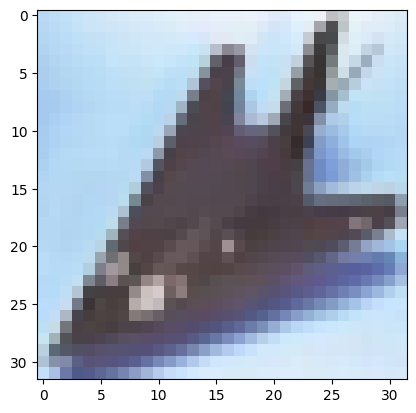

In [ ]:
pil_image = plot_image_sample(test_dataset)

Run a prediction request and get the predicted class.

In [ ]:
predictions = predict_from_image(pil_image, endpoint)

for pred in predictions:
    print("Predicted class:", pred)

Predicted class: plane


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
delete_endpoint = False
delete_model = False
delete_ray_cluster = False
delete_bucket = True
delete_tutorial = True

# Delete endpoint resource
if delete_endpoint:
    endpoint.delete(force=True)

# Delete model resource
if delete_model:
    registered_model.delete()

# Delete ray on vertex cluster
if delete_ray_cluster:
    vertex_ray.delete_ray_cluster(ray_cluster.cluster_resource_name)

# Delete tutorial folder
if delete_tutorial:
    shutil.rmtree(tutorial_path)

# Delete Cloud Storage objects that were created
if delete_bucket:
    ! gsutil -q -m rm -r $BUCKET_URI

NameError: name 'shutil' is not defined